In [60]:
import sys
import pathlib
import pickle
from sklearn.cluster import MiniBatchKMeans, KMeans

In [61]:
sys.path.insert(0, "src")
import data_functions
import embedding_functions
import cluster_functions
import util_functions

In [62]:
grascco_data = data_functions.DataProcessingFactory.load(
    pathlib.Path("./tmp/grascco_lokal/grascco_lokal_data.pickle")
)

In [63]:
grascco_embedding = embedding_functions.SentenceEmbeddingsFactory.load(
    pathlib.Path("./tmp/grascco_lokal/grascco_lokal_data.pickle"),
    pathlib.Path("./tmp/grascco_lokal/grascco_lokal_embedding.pickle")
)

In [5]:
#_clustering_cache = pathlib.Path("./tmp/test_grascco_cluster_cache.pickle")
# grascco_cluster = cluster_functions.PhraseClusterFactory.create(
#     sentence_embeddings=grascco_embedding,
#     cache_path=_clustering_cache,
#     cache_name="grascco",
#     cluster_algorithm="kmeans",
#     # kelbow_metric="silhouette",
#     kelbow_k=(10,50),
#     kelbow_estimator="kmeans-mb",
# )

---

In [64]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils.random import sample_without_replacement
from sklearn.linear_model import LinearRegression
from umap import UMAP
from yellowbrick.cluster import kelbow_visualizer

In [65]:
def fit_regression(x_reg, y_reg, degree=3, k_min=2):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(np.asarray(x_reg).reshape(-1,1))

    model = LinearRegression()
    model.fit(x_poly, np.asarray(y_reg))
    
    x_lin = np.linspace(np.asarray(x_reg).min(), np.asarray(x_reg).max(), 100)
    x_out = poly.transform(x_lin.reshape(-1,1))
    y_out = model.predict(x_out)
    x_reg = list(range(k_min)) + x_reg
    max_reg = np.asarray(x_reg)[np.argmax(y_out)]
    
    return x_lin, y_out, max_reg

In [66]:
_umap_params = {'n_neighbors': 50, 'metric':'cosine', 'min_dist':0.0,}
umap = UMAP(n_components=2, **_umap_params)
projection_umap_vis = umap.fit_transform(grascco_embedding.sentence_embeddings)
umap = UMAP(n_components=100, **_umap_params)
projection_umap_calc = umap.fit_transform(grascco_embedding.sentence_embeddings)

In [67]:
n_samples = 15
sample_fraction = 25
samples = []
for i in range(n_samples):
    samples.append(sample_without_replacement(projection_umap_vis.shape[0], int(projection_umap_vis.shape[0]/sample_fraction)))
mms = MinMaxScaler().fit(projection_umap_vis)

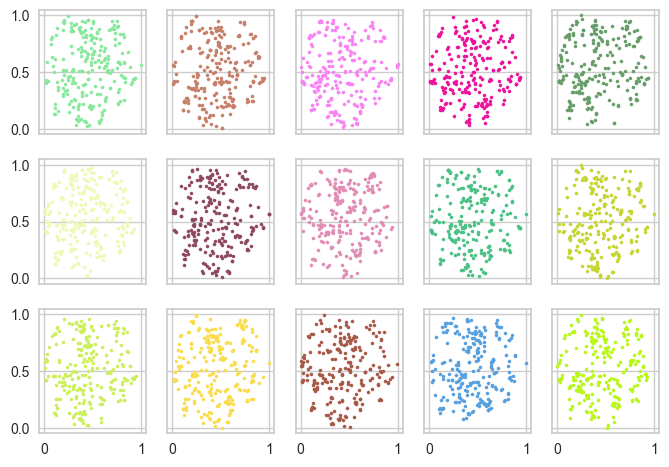

In [68]:
i = 0
_, axs = plt.subplots(3,5, sharex=True, sharey=True)
for _c in np.random.rand(n_samples,3):
    x = i%3
    y = i%5
    axs[x,y].scatter(*mms.transform(projection_umap_vis[samples[i]]).T, s=5, color=_c)
    i += 1
plt.show()

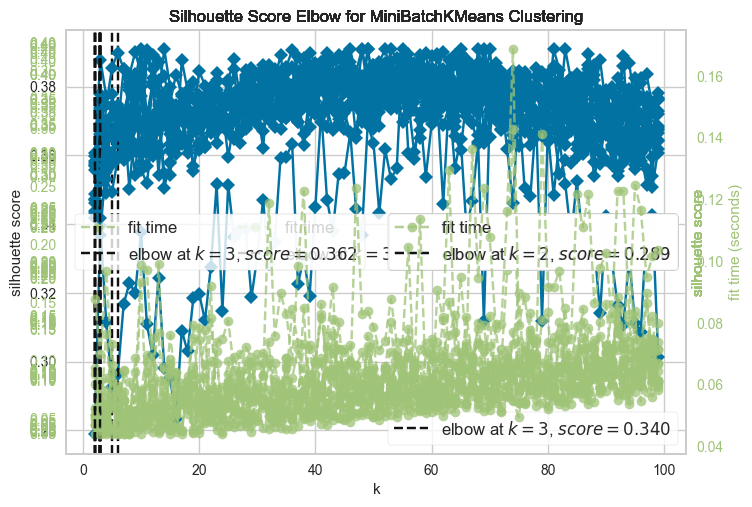

In [69]:
k_min = 2
kelbow = []
for _sample in samples:
    _kelbow = kelbow_visualizer(
        model=MiniBatchKMeans(n_init='auto'),
        X=projection_umap_calc[_sample],
        show=False,
        k=(k_min,100),
        metric='silhouette'
    )
    kelbow.append(_kelbow)


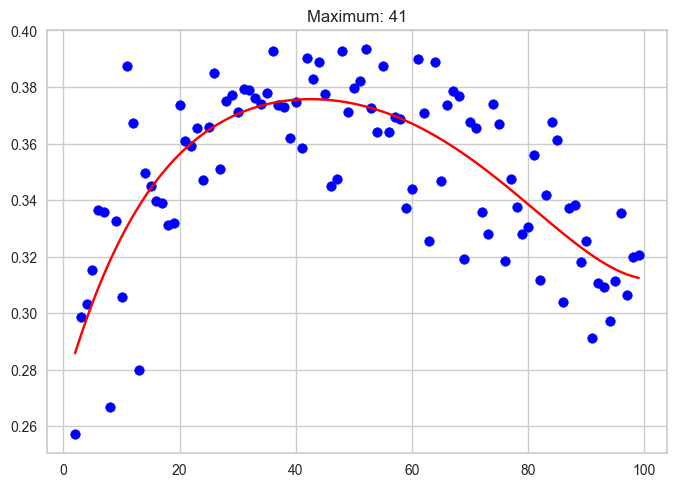

In [70]:
kelbow_val = kelbow[2]

x_vals, y_regression, max_regression = fit_regression(kelbow_val.k_values_, kelbow_val.k_scores_, 5)
plt.scatter(np.asarray(kelbow_val.k_values_).reshape(-1,1), np.asarray(kelbow_val.k_scores_), color='blue')
plt.plot(x_vals, y_regression, color='red')
plt.title(f"Maximum: {max_regression}")
plt.show()

In [71]:
_elbow_max = []
for _kelbow in kelbow:
    x_vals, y_regression, max_regression = fit_regression(_kelbow.k_values_, _kelbow.k_scores_, 5, k_min)
    _elbow_max.append(max_regression)

In [72]:
np.median(np.asarray(_elbow_max))

57.0

In [73]:
np.average(np.asarray(_elbow_max))

53.266666666666666

In [74]:
np.mean(np.asarray(_elbow_max))

53.266666666666666

In [75]:
_clustering_cache = pathlib.Path("./tmp/test_grascco_cluster_cache.pickle")
grascco_cluster = cluster_functions.PhraseClusterFactory.create(
    sentence_embeddings=grascco_embedding,
    cache_path=_clustering_cache,
    cache_name="grascco",
    cluster_by_down_scale=False,
    cluster_algorithm="kmeans",
    cluster_n_clusters=int(np.average(_elbow_max)),
    scaling_n_neighbors=50,
    scaling_metric='cosine',
    scaling_n_components=100,
    scaling_min_dist=0.0,
    kelbow_estimator=None
)

INFO:root:Building Concept Cluster ...
INFO:root:-- Clustering ...
INFO:root: (kmeans) with Arguments: {'n_clusters': 53}


Saved under: C:\Users\fra3066mat\PycharmProjects\concept-graphs\tmp\test_grascco_cluster_cache.pickle\grascco.pickle


In [76]:
grascco_embedding.sentence_embeddings.shape

(5965, 1024)

In [77]:
list(embedding_functions.show_top_k_for_concepts(
    grascco_cluster.concept_cluster,
    grascco_embedding
))

==Center 0==

	durchmesser
	querdurchmesser
	nachgeschaltete dünndarmschlinge
	ulzeriertem mm
	wandverdickten dünndarmschlinge
	minimale wandverdickungen
	bestehenden unterschenkelödeme
	unregelmässig begrenzten abschlussplatten
	unterschenkel
	zusätzlicher wandverdickung
	unterrand
	mm
	randwinkelerguss
	kleinfleckige verdichtungen
	distendierten stark luftgefüllten dünndarmschlingen


==Center 1==

	nachstationären bedarf
	stationäre aufnahme
	freiwilligen stationären aufnahme
	aktivierende pflege
	unterbringungsgründe


==Center 2==

	ausführliche besprechung
	zusammenfassung
	durchführung
	besprechung
	rücksprache
	entsprechender nachbericht
	anhaltspunkte
	verbesserung
	entsprechender vorbereitung
	aufnahmebeurteilung
	ausführliche aufklärung
	erbetene durchgeführte untersuchung
	vorbefund
	vorbereitung
	erklärung


==Center 3==

	steigerung
	erhöhung
	deutlichen verbesserung
	verbesserung
	durchführung
	leichte erhöhung
	maßgabe
	hervorr .
	anstieg
	befunderweiterung
	durchgeführ

[]